#  cosmoDC2 + redMaPPer - Ascaso-Extended Models Calibration


---
**License**

 Ascaso_Extended_cDC2_RM_Test

 Tue Aug 24 10:30:00 2021\
 Copyright  2021\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_cDC2_RM_Test\
 Copyright (C) 2021 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Functions
#from Configs_Ascaso_Ext_Analysis import Binningf

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import os


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
from clevar.match import output_matched_catalog
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf

import clevar

#Calibration functions

from RMCalib import FittingModel, BinningData

## Data

In [2]:
min_richness = 5
min_halo_mass = 1e13 #Msun

#Halos/Clusters
#CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

#CosmoDC2: 'cosmoDC2_v1.1.4_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

#Members
RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/cosmoDC2_RM_match_cross_membership')

# info = s_cf.plot(RM_cat, halo_cat, 'cross', col='mass', xscale='log', yscale='log',
#                  col_color='z', add_err=False)

RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    45,081
 * multiple (self):  43,213
 * multiple (other): 43,213
 * unique (self):    43,035
 * unique (other):   43,037
 * cross:            43,035

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    471,457
 * multiple (self):  75,785
 * multiple (other): 75,785
 * unique (self):    43,037
 * unique (other):   43,035
 * cross:            43,035


In [3]:
#Matched Data
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

In [4]:
clusters_dt = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['z']], names=('m200c', 'richness', 'redshift_true'))
# dt_halos = clusters_dt[np.logical_and(clusters_dt['redshift_true'] > 0.14, clusters_dt['redshift_true']< 0.33)]
# dt_halos = dt_halos[dt_halos['richness'] > 20]
dt_halos = clusters_dt

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)


In [5]:
R_min = min(dt_halos["richness"])
R_max = max(dt_halos["richness"])

len(z)

43035

### Training and test sets

In [6]:
X = pd.DataFrame({'m200c': list(dt_halos["m200c"]), 'redshift_true': list(dt_halos["redshift_true"])})
y = pd.DataFrame({'richness': list(dt_halos["richness"])})

cvd = FittingModel(dt_halos) #Fit object

data_train = cvd.cvdata(X,y)[0]
data_test = cvd.cvdata(X,y)[0]

# #Test  data
# data_test = pd.concat([X_test, y_test], axis=1)

# print( data_test.shape, X_test.shape, y_test.shape )
# print( data_train.shape, X_train.shape, y_train.shape )

# print( data_test.shape[0] + data_train.shape[0] )

# print( len(dt_halos) )

### Bins


In [7]:
bd = BinningData(dt_halos)
bin_f= bd.bin_meanf()
halos_mean = bin_f[0]

print(f'Total bins in halos_bin_mz: {len(bd.binningf())}')
print(f'Total bins in halos_mean: {len(bd.bin_meanf()[0])}')

hbmz = bd.binningf()

# print([len (item) for item in hbmz])
# print(bd.bin_meanf()[4])

Total bins in halos_bin_mz: 424
Total bins in halos_mean: 424


## Models fit

In [8]:
fm = FittingModel(data_train) #Fit object

### Ascaso Fit Params

Aqui fazemos o ajuste do modelo de ascaso e encontramos os valores dos parâmetros usando todos os dados em **dt_halos** (sem dividir em intervalos). 

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$



In [9]:
lnR_mean_ascaso, lnR_std_ascaso, ascaso = fm.model_fit('ascaso', dt_halos)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

### Ext (ln(1+z)) Fit Params

Aqui fazemos o ajuste do modelo extendido considerando a dependencia em $\ln (1 + z)$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [10]:
lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, ext_ln1pz = fm.model_fit('ext_ln1pz', dt_halos)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FRE

### Ext (z) Fit Params


Aqui consideramos o ajuste do modelo extendido considerando a dependência em $ z$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [11]:
lnR_mean_ext_z, lnR_std_ext_z, ext_z = fm.model_fit('ext_z', dt_halos)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FRE

## Plots Comparison

In [12]:
halos_mean = bd.bin_meanf()[0]


### Plot config

In [67]:
def Plot_model(model, data_set, mean):

    fig = plt.figure(figsize=(16,4))
#     gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
    
#     ax1 = fig.add_subplot(gs[0, :], projection='3d')
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    #Mu plot config ---------------------------------------
    if mean == True:
        #lnR model, z_mean, y_mean
        halos_mean = bd.bin_meanf()[0]
        lnR_mean = np.log(halos_mean["richness"])

        xs = halos_mean["redshift_true"]
        ys = np.log(halos_mean["m200c"])
        zs = model

        lb_model = '<$Ln\lambda$| M, z>'
        lb_binned = '$\ln \lambda_i$ médio'
        m = lnR_mean
        
        if f'{model}' == f'{lnR_mean_ascaso}': 
            fig.suptitle('Modelo de Ascaso')
        elif f'{model}' == f'{lnR_mean_ext_ln1pz}': 
            fig.suptitle('Modelo Estendido (ln(1 + z))')
        elif f'{model}' == f'{lnR_mean_ext_z}': 
            fig.suptitle('Modelo Estendido (z)')
        else: 
            pass
    
    #Std plot config ---------------------------------------
    else:
        halos_mean = bd.bin_meanf()[0]
        std_mean = bd.bin_meanf()[4]
    
        xs = halos_mean["redshift_true"]
        ys = np.log(halos_mean["m200c"])
        zs = model
        
        lb_model = '$\sigma_{\ln \lambda}$'
        lb_binned = '$\sigma^{i}$'
        m = std_mean
        
        if f'{model}' == f'{lnR_std_ascaso}': 
            fig.suptitle('Modelo de Ascaso', size=16)
        elif f'{model}' == f'{lnR_std_ext_ln1pz}': 
            fig.suptitle('Modelo Estendido (ln(1 + z))', size=16)
        elif f'{model}' == f'{lnR_std_ext_z}': 
            fig.suptitle('Modelo Estendido (z)', size=16)
        else: 
            pass
        
    #-------------------------------------------------------
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label= lb_model)

    ax2.scatter(ys, m, c='k', s=2.0, label=lb_binned)
    p2 = ax2.scatter(ys, zs , c= xs, s=2.0, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel(lb_model)
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(xs, m, c='k', s=2.0, label=lb_binned)
    p3 = ax3.scatter(xs, zs , c=ys, s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel(lb_model)
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()         
    plt.show()


### Mean

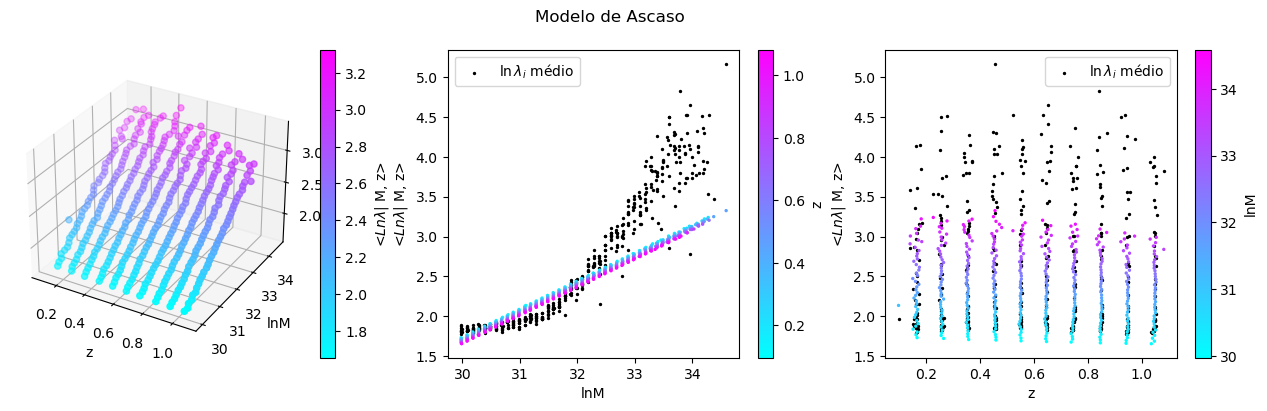

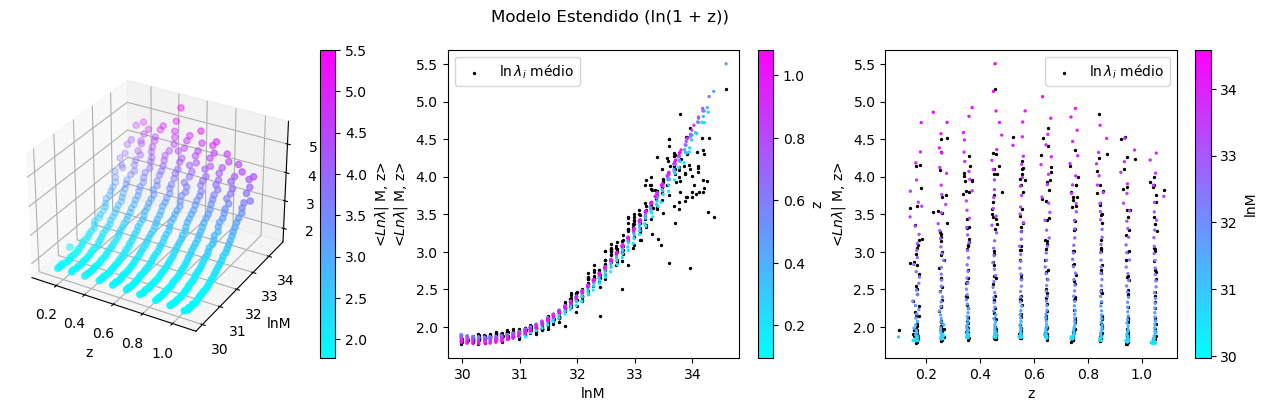

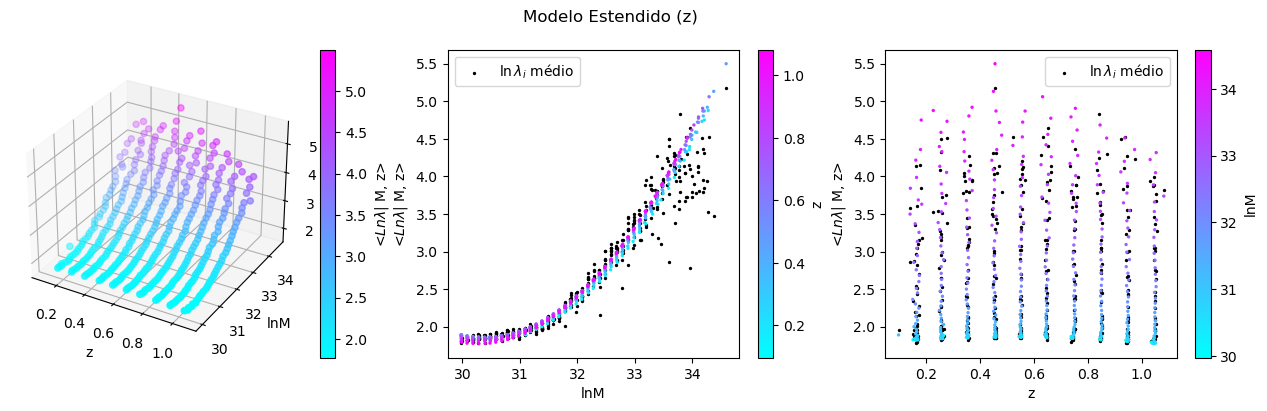

In [68]:
Plot_model(lnR_mean_ascaso, data_train, mean = True) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, data_train, mean = True) #Extended (ln(1 + z)) 
Plot_model(lnR_mean_ext_z, data_train, mean = True)

plt.show()

### Standard deviation

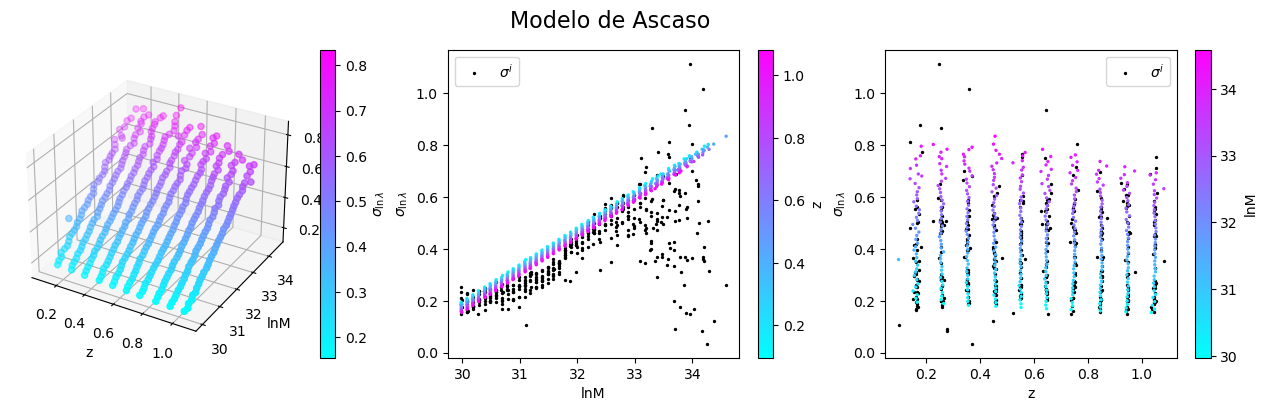

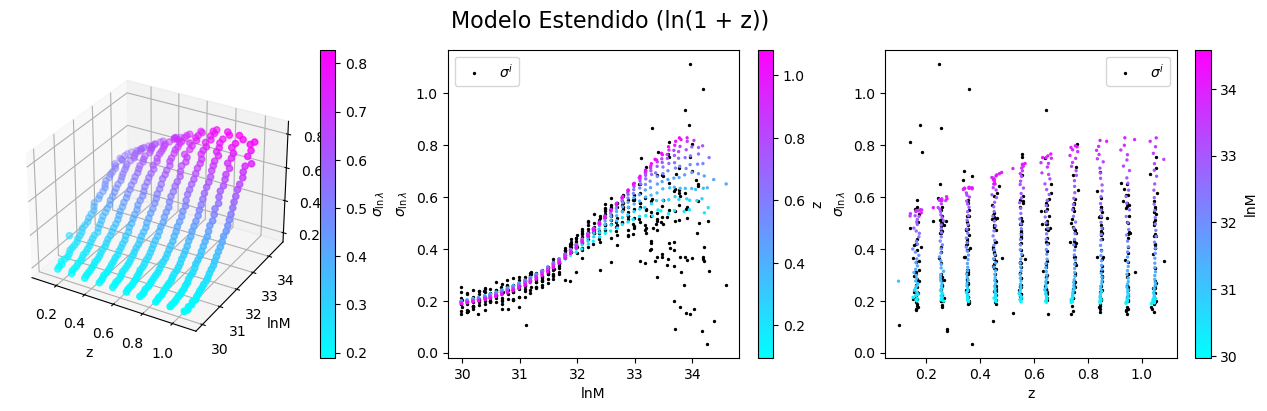

In [69]:
Plot_model(lnR_std_ascaso, data_train, mean=False) #Ascaso
Plot_model(lnR_std_ext_ln1pz, data_train, mean=False) #Extended (ln(1 + z)) 
#Plot_model_std(lnR_std_ext_z, data_train)

plt.show()

## Cross Validation

- Relative error:

\begin{equation}
Rel\_err = \frac{\left<\ln R_i | M_i, z_i \right> - {\mu^{i}}_{lnR}}{{\mu^{i}}_{lnR}}
\end{equation}

- Mean Square Error (MSE):

\begin{equation}
MSE = \frac{1}{N} \sum^{N} ({\mu^{i}}_{lnR} - \left<\ln R_i | M_i, z_i \right> )^2
\end{equation}

- Root Mean Square Error (RMSE):

\begin{equation}
RMSE = \sqrt{MSE}
\end{equation}


### Mean Relative Error

In [16]:
bd_test = BinningData(data_test)
bin_f_test= bd_test.bin_meanf()

In [17]:
# MEAN 
halos_mean = bin_f_test[0]

lnR_test = np.log(halos_mean["richness"])
lnM_test = np.log(halos_mean["m200c"])
z_test = halos_mean["redshift_true"]

ascaso_mean_valid = np.array( [ascaso.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])
ext_ln1pz_mean_valid = np.array([ext_ln1pz.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])

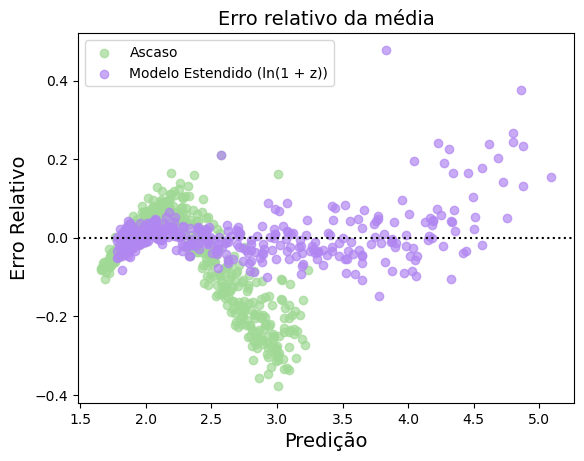

In [29]:
#Relative Error: Mean

#mean relative error
re_mean_ascaso = (ascaso_mean_valid - lnR_test)/ lnR_test
re_mean_ext_ln1pz = (ext_ln1pz_mean_valid - lnR_test)/ lnR_test

#Plot
plt.scatter(ascaso_mean_valid, re_mean_ascaso, c='#a0d995', alpha=0.7, label='Ascaso')
plt.scatter(ext_ln1pz_mean_valid, re_mean_ext_ln1pz, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')
plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
#plt.yscale('log')
plt.axhline(y=0.0, color='black', linestyle='dotted')

plt.title('Erro relativo da média', size=14)
plt.legend()
plt.show()

from sklearn.metrics import r2_score 


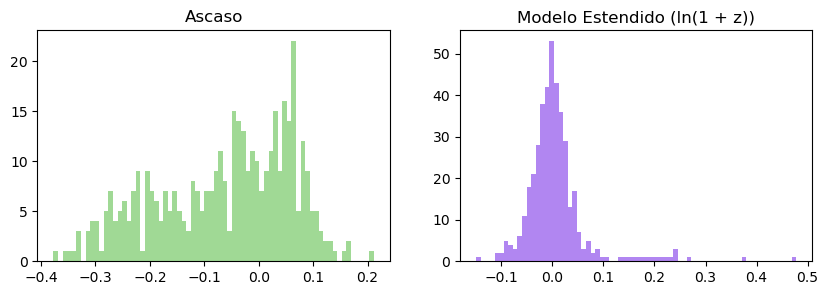

 Ascaso: p-value: 0.002102753592022985
 Extended: p-value: 2.604184136631146e-11


In [19]:
#Relative Error histogram

fig = plt.figure(figsize=(10,3))
ax1=plt.subplot(121)
ax2=plt.subplot(122)

ax1.hist(re_mean_ascaso, bins=70, color='#a0d995')
ax1.set_title('Ascaso')

ax2.hist(re_mean_ext_ln1pz, bins=70, color='#b186f1')
ax2.set_title('Modelo Estendido (ln(1 + z))')

plt.show()

print(f" Ascaso: p-value: {stats.kstest(re_mean_ascaso, stats.norm.cdf, args=(np.mean(re_mean_ascaso), np.std(re_mean_ascaso))).pvalue}")
print(f" Extended: p-value: {stats.kstest(re_mean_ext_ln1pz, stats.norm.cdf, args=(np.mean(re_mean_ext_ln1pz), np.std(re_mean_ext_ln1pz))).pvalue}")

### Mean MSE and RMSE

In [20]:
# Mean Square Error(MSE)
# Root Mean Square Error(RMSE)

MSE_ascaso = sum((lnR_test - ascaso_mean_valid) ** 2) / len(ascaso_mean_valid)
RMSE_ascaso = np.sqrt(MSE_ascaso)

MSE_ext_ln1pz = sum((lnR_test - ext_ln1pz_mean_valid) ** 2) / len(ext_ln1pz_mean_valid)
RMSE_ext_ln1pz = np.sqrt(MSE_ext_ln1pz )

print(f"Mean MSE and RMSE\n\nAscaso: \tMSE: {MSE_ascaso: .3f},\t RMSE:{RMSE_ascaso: .3f}")
print(f"Extended:\tMSE: {MSE_ext_ln1pz: .3f},\t RMSE:{RMSE_ext_ln1pz: .3f}\n")

Mean MSE and RMSE

Ascaso: 	MSE:  0.270,	 RMSE: 0.519
Extended:	MSE:  0.044,	 RMSE: 0.209



### Mean MAPE

In [21]:
print(f"MAPE:STD\n\nMAPE (Ascaso): {mean_absolute_percentage_error(lnR_test, ascaso_mean_valid) * 100: .2f}%") 
print(f"MAPE (Extended): {mean_absolute_percentage_error(lnR_test, ext_ln1pz_mean_valid) * 100: .2f}%") 

MAPE:STD

MAPE (Ascaso):  10.74%
MAPE (Extended):  3.54%


### Std Relative Error

In [22]:
bd_test = BinningData(data_test)
bin_f_test= bd_test.bin_meanf()

lnR_test_std = bin_f_test[4]

ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])

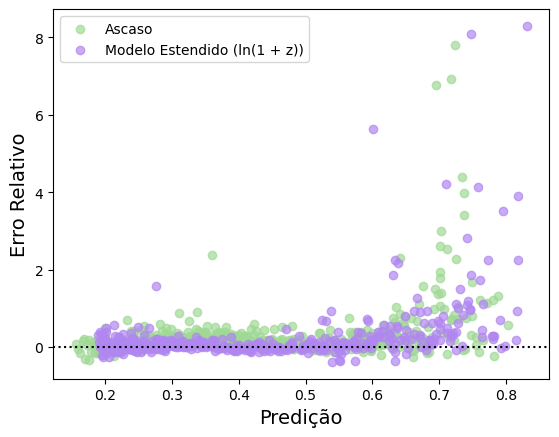

In [23]:
# STD 
#Relative Error: std
a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std

#Plot
plt.scatter(ascaso_std_valid, a_err, c='#a0d995', alpha=0.7, label='Ascaso')
plt.scatter(ext_ln1pz_std_valid, e_err, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')

plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')
#plt.title('Erro relativo do desvio padrão (< 10)', size=16)
#plt.yscale('log')
plt.legend()
plt.show()

### Std MSE and RMSE

In [24]:
MSE_ascaso_std = sum((lnR_test_std - ascaso_std_valid) ** 2) / len(ascaso_std_valid)
RMSE_ascaso_std = np.sqrt(MSE_ascaso_std)

MSE_ext_ln1pz_std = sum((lnR_test_std - ext_ln1pz_std_valid) ** 2) / len(ext_ln1pz_std_valid)
RMSE_ext_ln1pz_std = np.sqrt(MSE_ext_ln1pz_std )

print(f"Std MSE and RMSE\n\nAscaso: \tMSE: {MSE_ascaso_std: .3f},\t RMSE:{RMSE_ascaso_std: .3f}")
print(f"Extended:\tMSE: {MSE_ext_ln1pz_std: .3f},\t RMSE:{RMSE_ext_ln1pz_std: .3f}\n")

Std MSE and RMSE

Ascaso: 	MSE:  0.024,	 RMSE: 0.155
Extended:	MSE:  0.024,	 RMSE: 0.154



### Std MAPE

In [25]:
print(f"MAPE:STD\n\nMAPE (Ascaso): {mean_absolute_percentage_error(lnR_test_std, ascaso_std_valid) * 100: .2f}%") 
print(f"MAPE (Extended): {mean_absolute_percentage_error(lnR_test_std, ext_ln1pz_std_valid) * 100: .2f}%") 

MAPE:STD

MAPE (Ascaso):  36.42%
MAPE (Extended):  30.55%


In [26]:
lnR_test_std = bin_f[4]
ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])

a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std

cut =np.abs(a_err) < 300.0
a_err = a_err[cut]
ascaso_std_valid = ascaso_std_valid[cut]
lnR_test_std = lnR_test_std[cut]

MSE_ascaso_std = sum((ascaso_std_valid - lnR_test_std) ** 2) / len(ascaso_std_valid)
RMSE_ascaso_std = np.sqrt(MSE_ascaso_std)

lnR_test_std = bin_f[4]
cut2 = np.abs(e_err) < 300.0
e_err = e_err[cut2]
ext_ln1pz_std_valid = ext_ln1pz_std_valid[cut2]
lnR_test_std = lnR_test_std[cut2]

MSE_ext_ln1pz_std = sum((ext_ln1pz_std_valid - lnR_test_std) ** 2) / len(ext_ln1pz_std_valid)
RMSE_ext_ln1pz_std = np.sqrt(MSE_ext_ln1pz_std )

print(MSE_ascaso_std, RMSE_ascaso_std)
print(MSE_ext_ln1pz_std, RMSE_ext_ln1pz_std)

IndexError: index 412 is out of bounds for axis 0 with size 412

In [ ]:
bd = BinningData(data_test)
bin_f= bd.bin_meanf()

lnR_test_std = bin_f[4]

ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])